In [51]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import numpy as np
from scipy import stats



In [52]:
file_content = open('2024-03-08-19-00.txt', 'r').read()

In [53]:
benchmarking_pattern = re.compile(r"Benchmarking (\w+) (\w+)_([a-z]+):")
time_pattern = re.compile(r".* run \d+: (\d+)")

def process_content(content):
    data = collections.deque()
    current_runtime = ""
    current_module = ""
    current_language = ""
    times = []

    for line in content.splitlines():
        benchmarking_match = benchmarking_pattern.match(line)
        if benchmarking_match:
            if times:
                data.append(store_statistics(current_module, current_language, current_runtime, times))
                times = [] 
            current_runtime, current_module, current_language = benchmarking_match.groups()

        time_match = time_pattern.match(line)
        if time_match:
            times.append(int(time_match.group(1)))
    if times:
        data.append(store_statistics(current_module, current_language, current_runtime, times))

    return pd.DataFrame(list(data), columns=["module", "language", "runtime", "average", "min", "max", "90th_percentile", "std_deviation", "count", "trimmed_mean(90%)", "median", "mad", "q1", "q3"])

def store_statistics(module, language, runtime, times):
    times_array = np.array(times)
    times_array.sort()
    trimmed_mean = stats.mstats.trimmed_mean(times_array, limits=(0, 0.1))
    median = np.median(times_array)
    mad = np.median(np.abs(times_array - median)) 
    q1 = times_array[int(0.25 * len(times_array))]  
    q3 = times_array[int(0.75 * len(times_array))] 
    return (
        module,
        language,
        runtime,
        np.mean(times_array).astype(int),
        times_array[0].astype(int),  
        times_array[-1].astype(int),  
        times_array[int(0.90 * len(times_array))].astype(int),
        np.std(times_array).astype(int),
        len(times),
        trimmed_mean.astype(int),
        median.astype(int),
        mad.astype(int),
        q1.astype(int),
        q3.astype(int)
    )

data = process_content(file_content)
data

,module,language,runtime,average,min,max,90th_percentile,std_deviation,count,trimmed_mean(90%),median,mad,q1,q3
0,fib,c,bin,518188801,517688958,520479341,518415934,301933,500,518122734,518148702,123973,518034591,518284713
1,fib,c,wasmtime,906884073,904536691,910740417,907887861,995327,500,906668030,906868198,649689,906183548,907493215
2,fib,c,wasmer,934675414,930649067,951522361,938506641,2925446,500,933922059,933966831,1319024,932753469,935559856
3,fib,go,bin,317056404,316209370,319576888,317420277,315334,500,316996000,317077305,194463,316850518,317251166
4,fib,go,wasmtime,514151357,513400482,516595682,514529386,339822,500,514076857,514094730,190755,513938361,514326849
5,fib,go,wasmer,540985291,540399142,543652347,541286217,386139,500,540889440,540918182,155319,540777559,541089297
6,fib,rust,bin,453859720,452453375,784287987,452807504,18411845,500,452676528,452688679,54553,452636826,452747560
7,fib,rust,wasmtime,909714568,907260419,914503038,911116456,1087568,500,909476808,909581962,680467,908990476,910323667
8,fib,rust,wasmer,993042574,987603768,1002413083,998455540,3512120,500,992291019,991905509,2399398,990087774,995884666
9,get_wd,c,bin,100246785,99250147,102896525,101384348,694307,500,100089641,100069498,433857,99735013,100689131


In [54]:
data['runtime'] = data['runtime'].replace('bin', 'binary')
data = data.drop(columns=['std_deviation', 'count'])
binary_means = data[data['runtime'] == 'binary'].set_index(['module', 'language'])['trimmed_mean(90%)'].to_dict()

def calculate_ratio(row):
    key = (row['module'], row['language'])
    if key in binary_means:
        return row['trimmed_mean(90%)'] / binary_means[key]
    else:
        return np.nan

data['mean_ratio'] = data.apply(calculate_ratio, axis=1)
data['mean_ratio'] = data['mean_ratio'].round(2)
data

,module,language,runtime,average,min,max,90th_percentile,trimmed_mean(90%),median,mad,q1,q3,mean_ratio
0,fib,c,binary,518188801,517688958,520479341,518415934,518122734,518148702,123973,518034591,518284713,1.00
1,fib,c,wasmtime,906884073,904536691,910740417,907887861,906668030,906868198,649689,906183548,907493215,1.75
2,fib,c,wasmer,934675414,930649067,951522361,938506641,933922059,933966831,1319024,932753469,935559856,1.80
3,fib,go,binary,317056404,316209370,319576888,317420277,316996000,317077305,194463,316850518,317251166,1.00
4,fib,go,wasmtime,514151357,513400482,516595682,514529386,514076857,514094730,190755,513938361,514326849,1.62
5,fib,go,wasmer,540985291,540399142,543652347,541286217,540889440,540918182,155319,540777559,541089297,1.71
6,fib,rust,binary,453859720,452453375,784287987,452807504,452676528,452688679,54553,452636826,452747560,1.00
7,fib,rust,wasmtime,909714568,907260419,914503038,911116456,909476808,909581962,680467,908990476,910323667,2.01
8,fib,rust,wasmer,993042574,987603768,1002413083,998455540,992291019,991905509,2399398,990087774,995884666,2.19
9,get_wd,c,binary,100246785,99250147,102896525,101384348,100089641,100069498,433857,99735013,100689131,1.00


In [55]:
# measurements of these modules are effected by the loop module
# we need to subtract the measurements of the add module from the other modules
labels = ["time", "std_output", "dynamic_memory"]
measures = ['trimmed_mean(90%)', 'q1', 'q3', '90th_percentile', 'median']
for measure in measures:
    adjusted_measure = 'adjusted_' + measure
    data[adjusted_measure] = data[measure] 
    for label in labels:
            for runtime in data['runtime'].unique():
                for language in data['language'].unique():
                    adjustment = data.loc[(data['module'] == 'loop') & (data['runtime'] == runtime) & (data['language'] == language), measure].values[0]
                    data.loc[(data['module'] == label) & (data['runtime'] == runtime) & (data['language'] == language), adjusted_measure] -= adjustment

In [56]:
# adjusted mean ratio should be calculated after the subtraction
binary_means = data[data['runtime'] == 'binary'].set_index(['module', 'language'])['adjusted_trimmed_mean(90%)'].to_dict()
def calculate_ratio(row):
    key = (row['module'], row['language'])
    if key in binary_means:
        return row['adjusted_trimmed_mean(90%)'] / binary_means[key]
    else:
        return np.nan

data['adjusted_mean_ratio'] = data.apply(calculate_ratio, axis=1)
data['adjusted_mean_ratio'] = data['adjusted_mean_ratio'].round(2)
data

,module,language,runtime,average,min,max,90th_percentile,trimmed_mean(90%),median,mad,q1,q3,mean_ratio,adjusted_trimmed_mean(90%),adjusted_q1,adjusted_q3,adjusted_90th_percentile,adjusted_median,adjusted_mean_ratio
0,fib,c,binary,518188801,517688958,520479341,518415934,518122734,518148702,123973,518034591,518284713,1.00,518122734,518034591,518284713,518415934,518148702,1.00
1,fib,c,wasmtime,906884073,904536691,910740417,907887861,906668030,906868198,649689,906183548,907493215,1.75,906668030,906183548,907493215,907887861,906868198,1.75
2,fib,c,wasmer,934675414,930649067,951522361,938506641,933922059,933966831,1319024,932753469,935559856,1.80,933922059,932753469,935559856,938506641,933966831,1.80
3,fib,go,binary,317056404,316209370,319576888,317420277,316996000,317077305,194463,316850518,317251166,1.00,316996000,316850518,317251166,317420277,317077305,1.00
4,fib,go,wasmtime,514151357,513400482,516595682,514529386,514076857,514094730,190755,513938361,514326849,1.62,514076857,513938361,514326849,514529386,514094730,1.62
5,fib,go,wasmer,540985291,540399142,543652347,541286217,540889440,540918182,155319,540777559,541089297,1.71,540889440,540777559,541089297,541286217,540918182,1.71
6,fib,rust,binary,453859720,452453375,784287987,452807504,452676528,452688679,54553,452636826,452747560,1.00,452676528,452636826,452747560,452807504,452688679,1.00
7,fib,rust,wasmtime,909714568,907260419,914503038,911116456,909476808,909581962,680467,908990476,910323667,2.01,909476808,908990476,910323667,911116456,909581962,2.01
8,fib,rust,wasmer,993042574,987603768,1002413083,998455540,992291019,991905509,2399398,990087774,995884666,2.19,992291019,990087774,995884666,998455540,991905509,2.19
9,get_wd,c,binary,100246785,99250147,102896525,101384348,100089641,100069498,433857,99735013,100689131,1.00,100089641,99735013,100689131,101384348,100069498,1.00


In [57]:
def plot_module(module_name,scale='linear'):
    plt.figure(figsize=(10,6))
    barplot = sns.barplot(x='language', y='adjusted_trimmed_mean(90%)', hue='runtime', data= data[data['module'] == module_name])

    languages = data['language'].unique()
    runtimes = data['runtime'].unique()
    max_height = max([p.get_height() for p in barplot.patches])
    min_height = min([p.get_height() for p in barplot.patches]) + 1
    offset_ratio = 0.02  # Set the offset as a ratio of the bar height
    plt.yscale(scale)
    for i, p in zip(range(9), barplot.patches):
        height = p.get_height()
        language = languages[i % len(languages)]
        runtime = runtimes[i // len(languages)]
        row = data[(data['language'] == language) & (data['runtime'] == runtime) & (data['module'] == module_name)]
        ratio = row['adjusted_mean_ratio'].values[0]
        percentile_90 = row['adjusted_90th_percentile'].values[0]  
        if ratio != 1:
            barplot.text(p.get_x() + p.get_width() / 2, height * (1 + offset_ratio), f'{ratio}x', ha='center')
        plt.scatter(p.get_x() + p.get_width() / 2, percentile_90, color='red') 

    plt.scatter([], [], color='red', label='90th percentile')
    barplot.legend_.remove()

    plt.xlabel('Language')
    plt.ylabel('Time (ns)')
    print(f"Module: {module_name}")
    plt.show()

Module: fib


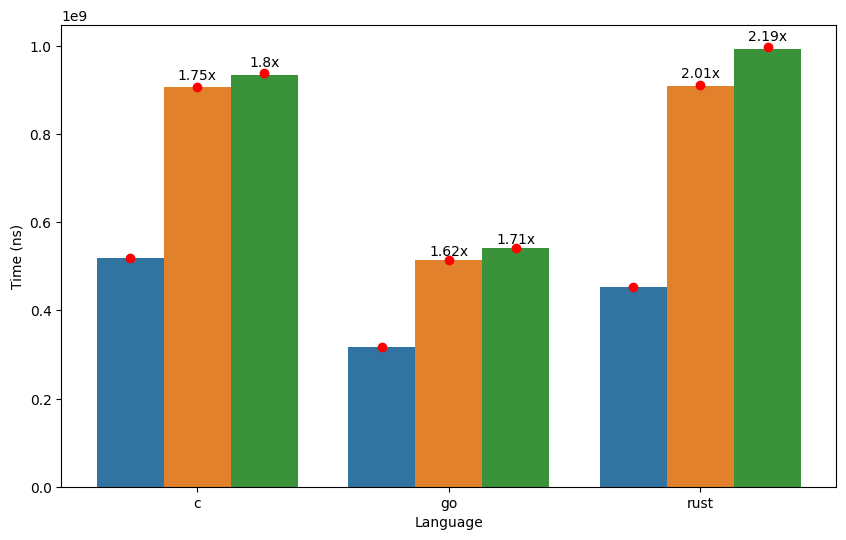

Module: get_wd


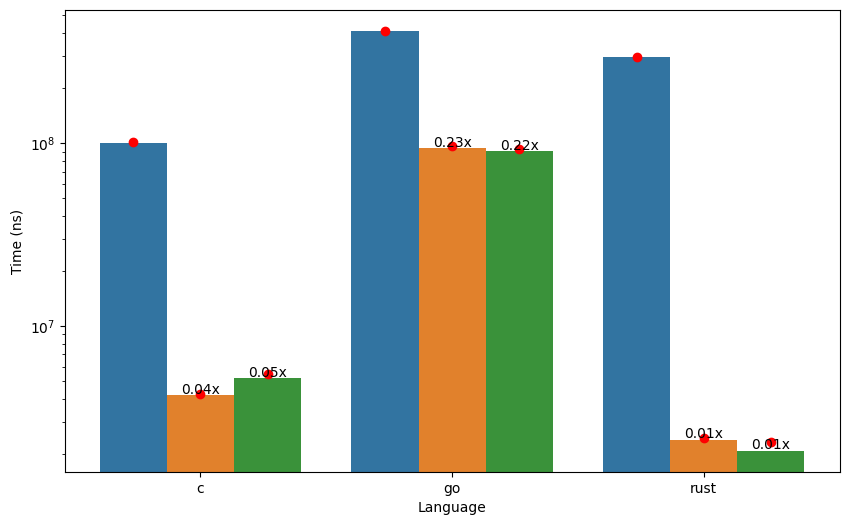

Module: loop


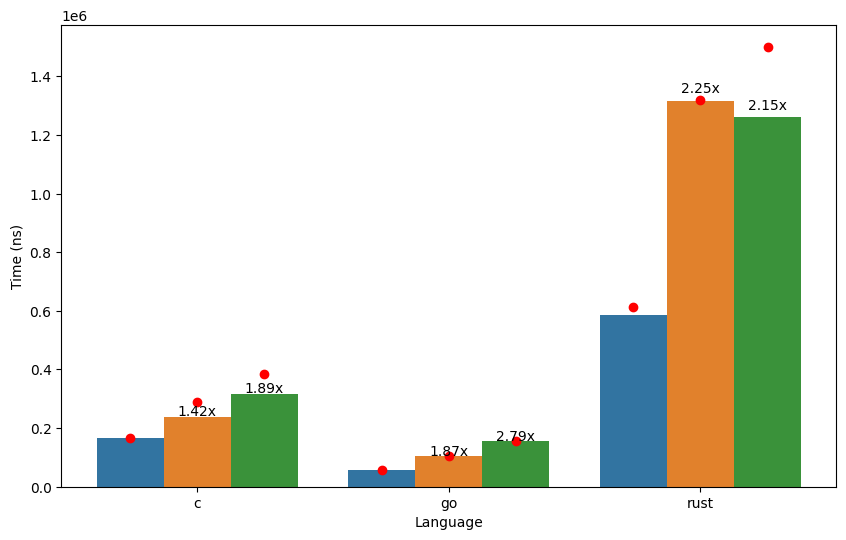

Module: dynamic_memory


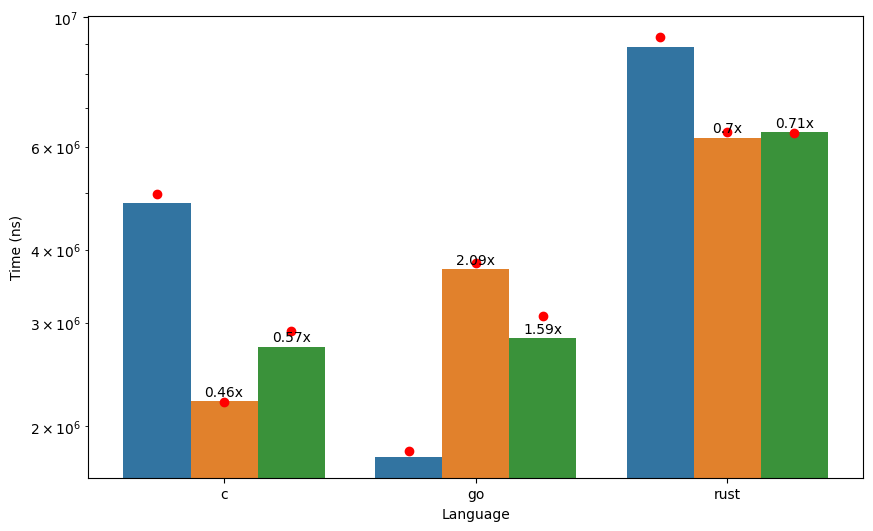

Module: std_output


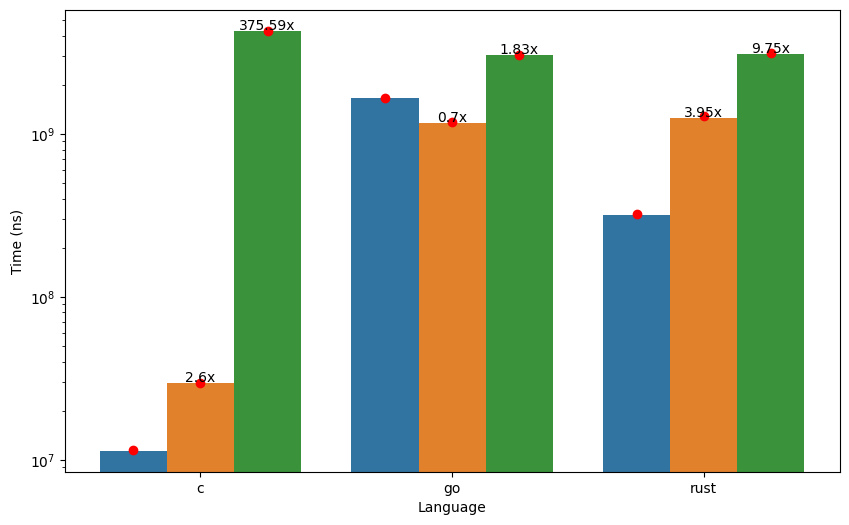

Module: time


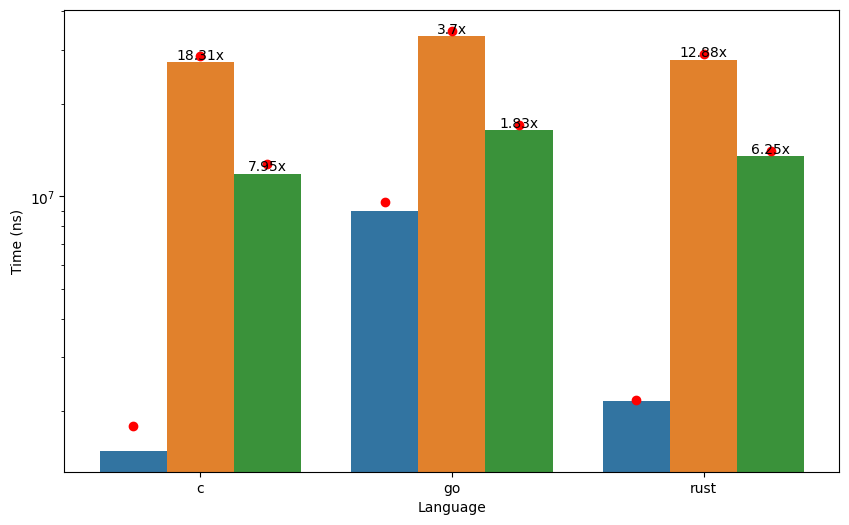

In [58]:
for module in data['module'].unique():
    if module in ['time', 'std_output', 'dynamic_memory','get_wd']:
        plot_module(module, 'log')
    else:
        plot_module(module)

In [63]:
def calculate_ratio(module):
    ratios = []
    for language in data['language'].unique():
        for runtime in data['runtime'].unique():
            row = data[(data['module'] == module) & (data['language'] == language) & (data['runtime'] == runtime)]
            ratio = row['adjusted_90th_percentile'].values[0] / row['adjusted_trimmed_mean(90%)'].values[0]
            ratio = round(ratio, 2)  
            ratios.append((language.title(), runtime.title(), ratio))  

    df = pd.DataFrame(ratios, columns=['Language', 'Runtime', 'Ratio'])

    df_pivot = df.pivot(index='Language', columns='Runtime', values='Ratio')
    df_pivot.index.name = None
    df_pivot = df_pivot[['Binary', 'Wasmtime', 'Wasmer']]
    df_pivot.to_csv('ratios_500_' + module + '.csv')
    return df_pivot

In [64]:
for module in data['module'].unique():
        calculate_ratio(module)

